In [2]:
import os
# os.chdir("Praesentation")
# os.chdir("voila")
# os.chdir("..")
os.getcwd()

'/Users/lwaetzig/Documents/B_Studium/2_SSM_1/A_Vorlesungsmaterial/1_Programmieren II/Praesentation/voila/notebooks'

# IMPORTS

In [18]:
import datetime as dt
import json
import os

import geopandas as gpd
import geopy
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import requests
from IPython.display import HTML, display
import ipywidgets as widgets


# DECLAIRE GLOBAL VARIABLES

In [4]:
icons = {
    "sun" : "figures/sun.png",
    "rain" : "figures/rain.png",
    "sun_cloud" : "figures/sun_cloud.png",
    "cloud" : "figures/cloud.png",
    "wind" : "figures/wind.png",
}
# define global vairables
API_KEY = "0903f43c667c445d4a0c16920ef81c36"
SHAPE_FILE = "data/germany_geo.json"

## Layout

### Widgets

In [29]:
textfield = widgets.Textarea(value="Please enter a city name")
display(textfield)

Textarea(value='Please enter a city name')

In [35]:
textfield.value

'Dresden'

### HTML LAYOUT

In [5]:
# create Header using HTML
title='WEATHER DASHBOARD'
HTML('<h1 style="font-size:30px;"><center>%s</center></h1>'%title)

In [6]:
subtitle1="Weather in whole Germany"
HTML('<h2 style="font-size:24px;"><center>%s</center></h2>'%subtitle1)

In [36]:
value = str(textfield.value).upper()
subtitle2 = f"Weather today in {value}"
HTML('<h2 style="font-size:24px;"><center>%s</center></h2>'%subtitle2)

## Function to get weather data for one specific 
The following function requests data from openweather api, prepare and store them in a pd.DataFrame. You have to pass a name of a city located in germany and the api key (already definded)


In [10]:
def get_weather_data_city(
    city_name: str,
    api_key: str
)-> pd.DataFrame:
    """function to get weather data for one specific city

    Args:
        city_name (str): name of city in germany
        api_key (str): necessary authentification to create api request

    Returns:
        pd.DataFrame: filled DataFrame with weather data from api
    """

    # get longitude and latitude for given city
    service = geopy.Nominatim(user_agent="myGeocoder")
    Location = service.geocode(f"{city_name}, Germany")

    # try to request api and store weather data
    try:
        url = (
            "https://api.openweathermap.org/data/2.5/onecall?lat=%s&lon=%s&appid=%s&units=metric"
            % (Location.latitude, Location.longitude, api_key)
        )
        response = requests.get(url)
        data = json.loads(response.text)
    except Exception as e:
        print(f"something went wrong: {e}")

    # if there is a failure code in the dataset stop and return None
    if "cod" in data.keys():
        print(data["cod"], data["message"])
        return None

    else:
        # only select hourly data from api request
        forecast = data["hourly"]

        # create, fill DataFrame for weather data and set timestamps as index
        weather_df = pd.DataFrame()
        weather_df["date"] = [
            dt.datetime.fromtimestamp(entry["dt"], pytz.timezone("Europe/Berlin"))
            for entry in forecast
        ]
        weather_df["temp"] = [entry["temp"] for entry in forecast]
        weather_df["feels_like"] = [entry["feels_like"] for entry in forecast]
        weather_df["pressure"] = [entry["pressure"] for entry in forecast]
        weather_df["uvi"] = [entry["uvi"] for entry in forecast]
        weather_df["clouds"] = [entry["clouds"] for entry in forecast]
        weather_df["weather"] = [entry["weather"][0]["main"] for entry in forecast]
        weather_df = weather_df.set_index("date", drop=True)

        return weather_df

### Vizualize data
-> using Matplotlib

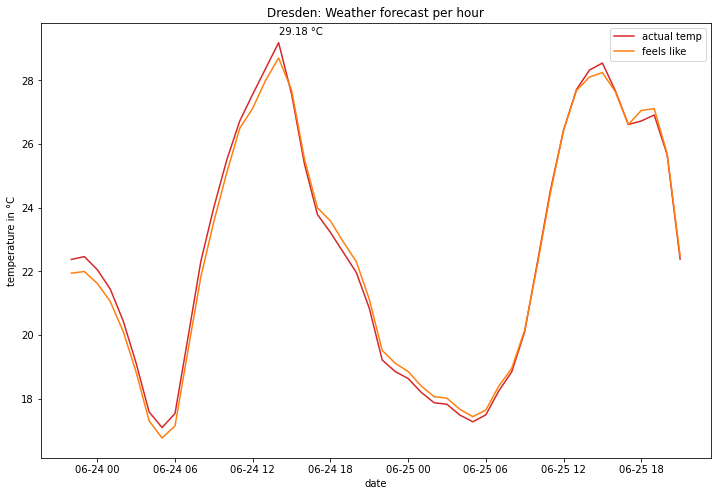

In [38]:
df = get_weather_data_city(city_name=textfield.value , api_key=API_KEY)

# define local maximum 
ymax = max(df["temp"])
xpos = np.where(df["temp"] == ymax)
xmax = df.index[xpos]

# create figure to plot
fig , axes = plt.subplots(figsize=(12,8))
# add to plots for temperature and feels like
axes.plot(df.index , df["temp"] , color = "tab:red" , label = "actual temp")
axes.plot(df.index , df["feels_like"] , color = "tab:orange" , label = "feels like")
axes.set_title(f"{textfield.value}: Weather forecast per hour")
axes.set_ylabel("temperature in °C")
axes.set_xlabel("date")
axes.legend(loc="upper right");
axes.annotate(f"{ymax} °C", xy=(xmax, ymax), xytext=(xmax, ymax + 0.25),);


## Weather data for whole Germany
The following function requests data from openweather api depending on the capital for each federal state, prepare and store the data in pd.DataFrame. The DataFrame also contains geological data of germany to visualize the weather data.

In [19]:
def get_weather_data_germany(
    api_key: str,
    shape_file: str,
) -> pd.DataFrame:
    """get geological data using shapefile and weather data using api request from openweather-api

    Args:
        api_key (str): necessary authentification to create api request
        shape_file (str): shape file for germany map used to plot with geopandas

    Returns:
        pd.DataFrame: prepared DataFrame
    """

    # read in shapefile and remove unnecessary columns
    germany = gpd.read_file(shape_file)
    germany = germany.drop(columns=["type", "id"])

    # add capitals for each federal state
    capital = [
        "Stuttgart",
        "Muenchen",
        "Berlin",
        "Potsdam",
        "Bremen",
        "Hamburg",
        "Wiesbaden",
        "Schwerin",
        "Hannover",
        "Düsseldorf",
        "Mainz",
        "Saarbrücken",
        "Magdeburg",
        "Dresden",
        "Kiel",
        "Erfurt",
    ]
    germany["capital"] = capital

    # get latitude and longitude for each capital and append it to DataFrame
    service = geopy.Nominatim(user_agent="myGeocoder")
    for i, row in germany.iterrows():
        location = service.geocode(f"{row['capital']}, Germany")
        germany.loc[i, "lat"] = location.latitude
        germany.loc[i, "lon"] = location.longitude

    # get current weather data for each capital in DataFrame
    for i, row in germany.iterrows():
        try:
            url = (
                "https://api.openweathermap.org/data/2.5/onecall?lat=%s&lon=%s&appid=%s&units=metric"
                % (row["lat"], row["lon"], api_key)
            )
            response = requests.get(url)
            data = json.loads(response.text)
        except Exception as e:
            print(e)

        # if there is a failue code in dataset continue with next city
        if "cod" in data.keys():
            print(row["name"], data["message"])
            continue

        # fill DataFrame with weather data from api request
        else:
            germany.loc[i, "temp"] = data["current"]["temp"]
            germany.loc[i, "feels_like"] = data["current"]["feels_like"]
            germany.loc[i, "weather_type"] = data["current"]["weather"][0]["main"]
            germany.loc[i, "pressure"] = data["current"]["pressure"]
            germany.loc[i, "uvi"] = data["current"]["uvi"]
            germany.loc[i, "clouds"] = data["current"]["clouds"]

    return germany

### Vizualize Germany-map
-> using geopandas

Text(0.5, 1.0, 'Weather in Germany')

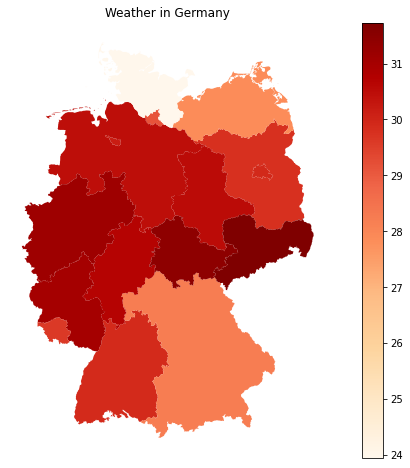

In [20]:
df_germany = get_weather_data_germany(API_KEY, SHAPE_FILE)
df_germany.plot(column="temp", legend=True, cmap="OrRd" , figsize=(12,8)).set_axis_off()